# DDIM Scheduler and Stable Diffusion 2.
### Aim 1: Generate Fake images, for an input image
### Aim 2: Compute DIRE
### Aim 3: train a classifier to detect fake and real images based on DIRE

## AIM 1: Generate Fake Images for an input image

In [21]:
## Write the pipeline to generate fake images using DDIM And stable diffusion.
from huggingface_hub import login
from diffusers import StableDiffusionPipeline, DDIMScheduler
import torch

repo_id = "stabilityai/stable-diffusion-2-base"
ddim = DDIMScheduler.from_pretrained(repo_id, subfolder="scheduler")
pipeline = StableDiffusionPipeline.from_pretrained(repo_id, scheduler=ddim, use_safetensors=True, image_encoder = ).to('cuda')

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [10]:
pipeline.scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.00085),
            ('beta_end', 0.012),
            ('beta_schedule', 'scaled_linear'),
            ('trained_betas', None),
            ('clip_sample', False),
            ('set_alpha_to_one', False),
            ('steps_offset', 1),
            ('prediction_type', 'epsilon'),
            ('thresholding', False),
            ('dynamic_thresholding_ratio', 0.995),
            ('clip_sample_range', 1.0),
            ('sample_max_value', 1.0),
            ('timestep_spacing', 'leading'),
            ('rescale_betas_zero_snr', False),
            ('_use_default_values',
             ['clip_sample_range',
              'prediction_type',
              'thresholding',
              'sample_max_value',
              'rescale_betas_zero_snr',
              'dynamic_thresholding_ratio',
              'timestep_spacing']),
            ('_class_name', 'DDIMScheduler'),
            ('_diffusers_version', '0.26.3'),
         

  0%|          | 0/50 [00:00<?, ?it/s]

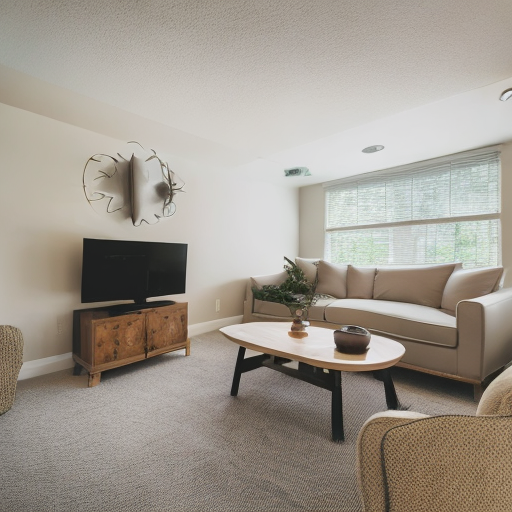

In [66]:
import requests
from PIL import Image
from io import BytesIO
url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"

image = '/data/upb/users/b/bakshit/profiles/unix/cs/FraudDetectionThesis/data/real/lsun/bedroom/2.jpg'
image = Image.open(image)
image = image.resize((512, 512))

prompt = "a living room with a couch, chair, and a window"

generator = torch.Generator(device="cuda").manual_seed(8)
gen_image = pipeline(image=image, prompt=prompt, generator=generator).images[0]
gen_image

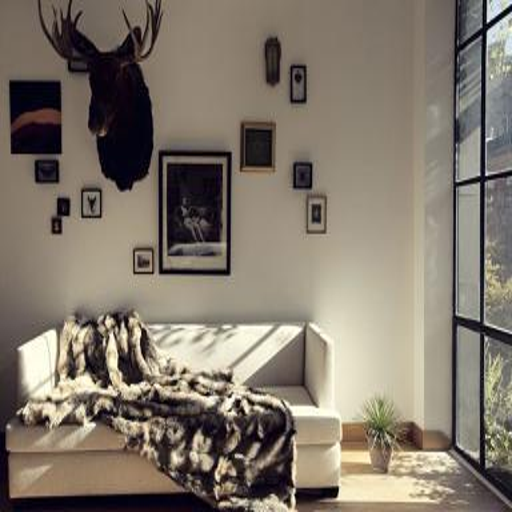

In [35]:
image

## Aim 2: Compute DIRE
#### DIRE = torch.absolute(input_image-reconst_image)

In [41]:
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
])
# image = Image.open(image)
im_input = transform(image)
im_gen = transform(gen_image)

In [43]:
dire_diff = torch.abs(im_input - im_gen)
dire_diff.shape

torch.Size([3, 512, 512])

### using clipimageprocessor to extract image embeddings. probably the embedding is resized image embedding, something we dont want

In [68]:
tensored_gen = torch.tensor(pipeline.feature_extractor(images=gen_image)['pixel_values'][0])
tensored_gen.shape

torch.Size([3, 224, 224])

In [73]:
tensored_input = torch.tensor(pipeline.feature_extractor(images=image)['pixel_values'][0])
tensored_input.shape

torch.Size([3, 224, 224])

In [75]:
dired = torch.abs(tensored_input - tensored_gen)

In [77]:
dired

tensor([[[0.4380, 0.4380, 0.4380,  ..., 0.5547, 0.5255, 0.5547],
         [0.4671, 0.4380, 0.4526,  ..., 0.4380, 0.7153, 0.3212],
         [0.4088, 0.4380, 0.4234,  ..., 0.7445, 0.0000, 1.6350],
         ...,
         [1.2555, 1.2847, 1.2993,  ..., 1.3431, 1.0511, 0.4380],
         [1.1533, 1.2555, 1.1387,  ..., 1.3431, 1.4598, 1.1679],
         [1.0511, 1.2117, 1.1387,  ..., 1.4306, 1.4452, 1.4598]],

        [[0.5853, 0.5703, 0.5703,  ..., 0.9005, 0.8705, 0.9155],
         [0.6003, 0.5703, 0.5853,  ..., 0.7804, 1.0505, 0.6603],
         [0.5403, 0.5853, 0.5553,  ..., 1.0806, 0.3002, 1.3807],
         ...,
         [1.3657, 1.3957, 1.4257,  ..., 1.1706, 0.8554, 0.1951],
         [1.2156, 1.3657, 1.2456,  ..., 1.1556, 1.2757, 0.9605],
         [1.1256, 1.3207, 1.2607,  ..., 1.2607, 1.2306, 1.2456]],

        [[0.5688, 0.5546, 0.5546,  ..., 0.7110, 0.9954, 1.3082],
         [0.5830, 0.5404, 0.5688,  ..., 0.6115, 1.1945, 1.0665],
         [0.5404, 0.5688, 0.5404,  ..., 0.9527, 0.4835, 0.

### using CLIPVisionModelwith projection to create image embeddings.

In [100]:
from PIL import Image
import requests
from transformers import AutoProcessor, CLIPVisionTransformer

model = CLIPVisionTransformer.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")


image_input_p = processor(images=image, return_tensors="pt")
image_gen_p = processor(images=gen_image, return_tensors="pt")

outputs_input_p = model(**image_input_p)
outputs_gen_p = model(**image_gen_p)
input_embeds = outputs_input_p.pooler_output
gen_embeds = outputs_gen_p.pooler_output

ImportError: cannot import name 'CLIPVisionTransformer' from 'transformers' (/data/upb/users/b/bakshit/profiles/unix/cs/FraudDetectionThesis/venv/lib/python3.9/site-packages/transformers/__init__.py)

In [93]:
dire_new = torch.abs(input_embeds-gen_embeds)
dire_new.shape

torch.Size([1, 768])

In [94]:
dire_new

tensor([[1.1618e+00, 3.5887e-01, 2.6453e-01, 3.2643e-01, 2.0112e-01, 5.7076e-01,
         2.9307e-01, 1.9560e-01, 1.1065e+00, 1.2074e+00, 5.7192e-01, 1.0655e+00,
         4.7851e-01, 7.5705e-01, 2.7427e-01, 5.1331e-01, 1.6294e+00, 3.4195e-01,
         3.5578e-01, 1.8770e-01, 2.2115e-01, 6.4758e-01, 6.3990e-01, 1.2203e+00,
         4.5506e-01, 1.7737e+00, 1.0713e+00, 5.8353e-01, 1.3703e+00, 6.8282e-01,
         7.0614e-01, 4.7414e-01, 8.1214e-01, 8.9071e-02, 8.1918e-01, 3.4148e-01,
         5.8136e-01, 4.0982e-01, 1.0897e+00, 3.6566e-02, 4.4353e-01, 6.7397e-01,
         6.8344e-01, 1.7228e-01, 3.7097e-01, 2.9727e-01, 4.6840e-02, 2.9631e+00,
         1.2778e+00, 4.5001e-01, 1.1428e-01, 1.8682e+00, 5.7804e-01, 1.3141e+00,
         1.3225e+00, 2.5182e+00, 4.5997e-01, 3.9786e-01, 1.1131e+00, 5.6046e-01,
         1.0222e+00, 1.2159e+00, 1.0023e+00, 1.2780e+00, 7.7216e-01, 4.3644e-01,
         4.5507e-03, 1.3518e-01, 1.4352e+00, 2.0202e-01, 5.1275e-01, 4.4395e-01,
         5.2635e-01, 1.3144e